# 2.5 非参数方法

之前我们的方法都是预先假设数据服从一个特定的概率分布，然后对对这个分布的参数进行估计。这种方法叫做参数估计。

但是这种方法的缺陷在于，我们选择的分布可能与实际的分布相差很大：如果数据是个多峰的分布，那么我们用一个高斯分布很难得到一个较好的结果。

非参数方法与参数估计不同，非参数方法对于数据分布的假设通常是很少的。

我们先从直方图来入手。考虑一个连续变量 $x$，直方图方法将 $x$ 划分为 $n$ 个长度为 $\Delta_i$ 的区间，每个区间内观察到的数据点数为 $n_i$，总的数据点为 N，那么我们可以认为，在第 $i$ 个区间的概率密度可以近似为：

$$
p_i = \frac{n_i}{N\Delta_i}
$$

即我们认为在每个区间它的概率密度是相同的。然后我们显然有 $\int p(x) dx = 1$。在实际应用中，我们通常让这些区间等长即 $\Delta_i = \Delta$。

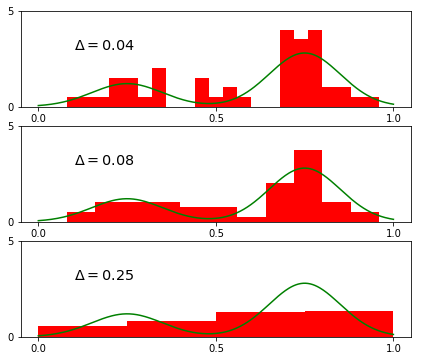

In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.stats import norm

%matplotlib inline

_, axes = plt.subplots(3, 1, figsize=(7,6))

xx = np.zeros(50)

n = 15
xx[:n] = norm.rvs(size=(n,), loc=0.25, scale=0.1)
xx[n:] = norm.rvs(size=(50-n,), loc=0.75, scale=0.1)

dlt = [0.04, 0.08, 0.25]
tt = np.linspace(0, 1, 300)
tp = 0.3 * norm.pdf(tt, loc=0.25, scale=0.1) + 0.7 * norm.pdf(tt, loc=0.75, scale=0.1)

for i in range(3):
    axes[i].hist(xx, bins=np.arange(0,1.01,dlt[i]), normed=True, color='r')
    axes[i].plot(tt, tp, 'g')
    axes[i].set_ylim(0, 5)
    axes[i].set_yticks([0, 5])
    axes[i].set_xticks([0, .5, 1])
    axes[i].text(0.1, 3, '$\Delta={}$'.format(dlt[i]), fontsize='x-large')

plt.show()

上图是两个高斯分布的混合，绿色为实际的概率分布，我们看到，当我们将 $\Delta$ 设的很小时，很多区域的信息被丢失了，当 $\Delta$ 设的很大时，又不能很好的反映出多峰的性质。

在实际应用中，直方图方法只能用在一维或者二维的情况，当维数多的时候并不适合。

我们使用直方图方法的原因基于两个考虑，第一，对于某个位置的概率密度，我们通常会考虑该点附近某个区域内的数据点的情况，直方图的区间宽度控制了这个区域的大小；第二，直方图的区间宽度选择事实上控制了我们模型的复杂度。考虑这两个因素，我们引入两种广泛使用的非参数估计方法

## 2.5.1 核密度估计量

考虑估计 $D$ 维空间的一个未知概率分布 $p(\mathbf x)$ 的问题，我们考虑 $\bf x$ 附近包含它的一个小区域 $\mathcal R$，这个小区域内的概率质量为：

$$
P=\int_{\mathcal R} p(\mathbf x) d\mathbf x
$$

假设现在我们有 $N$ 个观测点；对于这 N 个点来说，它有 $P$ 的概率落在区域 $\mathbf R$ 中，所以有 $K$ 个数据点落在 $\mathbf R$ 中的概率是一个二项分布，概率为

$$
\mathrm{Bin}(K| N, P)=\frac{N!}{K!(N-K)!}P^{K}(1-P)^{N-K}
$$

利用二项分布的性质，我们知道
$\mathbb E[K/N] = P$
和
$\mathrm{var}[K/N]=P(1-P)/N$，当 $N$ 足够大时，我们有：

$$K\simeq NP$$

当区域 $\mathcal R$ 足够小时，我们有：

$$P\simeq p(\mathbf x)V$$

其中 $V$ 是区域的体积，这样我们就得到估计值：

$$
p(\mathbf x) = \frac{K}{NV}
$$

对于 $\mathcal R$ 的选择，我们要让它足够小，从而 $p(\mathbf x)$ 可以认为是一个常数；但是要足够大，使得落在这个区域的次数 $K$ 能在均值附近出现峰值。

当我们固定 $K$，然后决定适合的 $V$ 时，对应的是 $K$ 近邻的方法，当我们固定 $V$ 找 $K$ 的时候，对应的是核方法。

当 $N\to\infty$ 的时候，这两种方法在 $V, K$ 随 $N$ 增大而分别减小和增大的情况下都会收敛到真实分布。





### 核函数方法

我们将区域 $\mathcal R$ 限制为以 $\bf x$ 为中心的一个小立方体。为了计算落在这个区域的数据点数 $K$ 我们定义这样的函数：

$$
k(\mathbf u) = \left\{
\begin{aligned}
1, &~|u_i| \leq 1/2, i=1,\dots,D \\
0, &~{\rm otherwise}
\end{aligned}
\right.
$$

它表示数据点是否落在以原点为中心的单位立方体。

$k(\mathbf u)$ 就是一个核函数的例子，在这个问题上，更确切的说法应该是 Parzen 窗函数。

从上面的式子可以看出落在，$k(\frac{\mathbf{x-x}_n}{h})$ 表示数据点 ${\bf x}_n$ 是否以 $\mathbf x$ 为中心，边长为 $h$ 的区域。因此，落在这个区域的数据点总数为：

$$
K = \sum_{n=1}^N k(\frac{\mathbf{x-x}_n}{h})
$$

从而概率密度的估计值为

$$
p({\bf x})=\frac{1}{N} \sum_{n=1}^N \frac{1}{h^D} k(\frac{\mathbf{x-x}_n}{h})
$$

与直方图法一样，这种方法面临的一个问题是在边界上的不连续性。我们可以考虑一个更加光滑的核函数，比如说最常见的高斯核函数，考虑上式的形式，我们给出一个类似的表达式：

$$
p({\bf x})=\frac{1}{N} \sum_{n=1}^N \frac{1}{(2\pi h^2)^{1/2}} \exp(-\frac{\|\mathbf{x-x}_n\|}{2h^2})
$$

这里 $h$ 对应的是高斯成分的标准差。

当我们更换了核函数的时候，为了保证概率密度是归一的，求和的部分通常也要满足概率密度的归一性。

通常，核函数满足的条件为

$$
\begin{align}
k(\mathbf u) & \geq 0 \\
\int k(\mathbf u)d\mathbf u & = 1
\end{align}
$$

如图所示为高斯核函数在不同 $h$ 下的拟合结果。

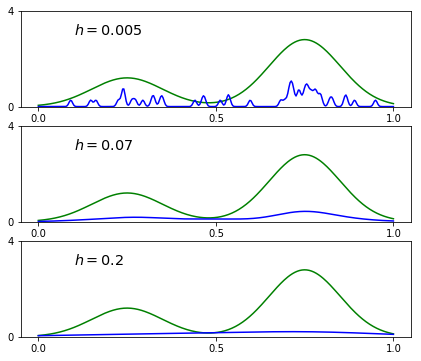

In [14]:
_, axes = plt.subplots(3, 1, figsize=(7,6))

h = 0.005, 0.07, 0.2

for i in range(3):
    tq = np.zeros_like(tp)
    for x in xx:
        tq += norm.pdf(tt, loc=x,scale=h[i])/len(tt)
    axes[i].plot(tt, tp, 'g')
    axes[i].plot(tt, tq, 'b')
    axes[i].set_ylim(0, 4)
    axes[i].set_yticks([0, 4])
    axes[i].set_xticks([0, .5, 1])
    axes[i].text(0.1, 3, '$h={}$'.format(h[i]), fontsize='x-large')
    
plt.show()

## 2.5.2 近邻方法

在核方法中，一旦我们选定了 $h$，我们就相当于固定了体积 $V$（分别对应于上一节的 $h^D, (2\pi h^2)^{1/2}$）。

现在我们考虑固定 $K$ 的情况，此时我们需要找到一个合适的 $V$ 使得落在体积 $V$ 中的点正好为 $K$ 个。

为了方便，我们考虑点 $\bf x$ 的一个球域，这个球域正好包含 $K$ 个数据点。此时，球的体积由离 $\bf x$ 第 $K$ 近的点决定。

该点的密度近似为：

$$
p(\mathbf x)=\frac{K}{NV}
$$

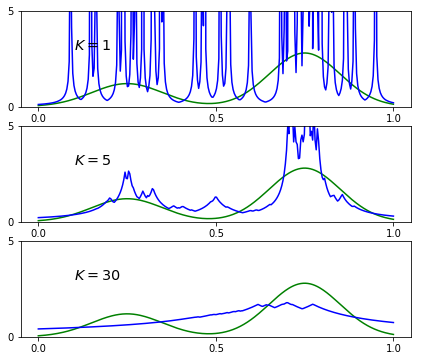

In [4]:
_, axes = plt.subplots(3, 1, figsize=(7,6))

K = 1, 5, 30
N = 50.0

for i in range(3):
    tq = np.zeros_like(tt)
    for j, t in enumerate(tt):
        dd = np.abs(xx - t)
        dd.sort()
        tq[j] = K[i] / N / (2 * dd[K[i]-1]) 
    axes[i].plot(tt, tp, 'g')
    axes[i].plot(tt, tq, 'b')
    axes[i].set_ylim([0, 5])
    axes[i].set_yticks([0, 5])
    axes[i].set_xticks([0, .5, 1])
    axes[i].text(0.1, 3, '$K={}$'.format(K[i]), fontsize='x-large')
    
plt.show()

不同 $K$ 的拟合结果如上图所示。

### 拓展到分类问题

假设我们有 N 个数据点，第 $\mathcal C_k$ 类有 $N_k$ 个，从而 $\sum_{k} N_k = N$。

对于一个新数据点 $\bf x$，我们找到包含 K 个点的体积为 $V$ 的区域，从而总的概率密度近似为：

$$
p(\mathbf x)=\frac{K}{NV}
$$

在这个区域中，第 $\mathcal C_k$ 类有 $K_k$ 个，条件概率密度近似为：

$$
p(\mathbf x|\mathcal C_k)=\frac{K_k}{N_kV}
$$

而类别的先验为：

$$
p(\mathcal C_k) = \frac{N_k}{N}
$$

于是贝叶斯定理给出：

$$
p(\mathcal C_k|\mathbf x) = \frac{p(\mathbf x|\mathcal C_k)p(\mathcal C_k)}{p(\mathbf x)} = \frac{K_k}{K}
$$

最小错误率决策给出，我们要将 $\bf x$ 标记为 $p(\mathcal C_k|\mathbf x)$ 即 $K_k / K$ 最大的那个类。

所以为了对新数据点进行决策，我们首先找到离它最近的 $K$ 个点，然后将数据点划分为 $K$ 个点中最多的那个类；数目相同则随机选取一类。

当 $K = 1$ 时，这对应于最近邻规则，即新数据点的标签为离它最近的数据点的类别。

对于最近邻规则，当 $N\to\infty$ 时，它的错误里不会超过使用真实分布进行判断的最小错误率的两倍。

当然，核方法和近邻法的一个缺点在于我们需要存储所有的训练数据。